In [1]:
import numpy as np
import pandas as pd

In [2]:
import yfinance as yf

df = yf.download('INTC', start="2016-01-01")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,33.880001,34.009998,33.459999,33.990002,27.142990,27882200
2016-01-05,33.959999,34.000000,33.529999,33.830002,27.015223,16709500
2016-01-06,33.250000,33.520000,32.799999,33.080002,26.416306,25491300
2016-01-07,32.279999,33.009998,31.840000,31.840000,25.426088,37680500
2016-01-08,32.090000,32.220001,31.430000,31.510000,25.162563,29953800
...,...,...,...,...,...,...
2024-04-05,39.349998,39.459999,38.509998,38.709999,38.709999,67189100
2024-04-08,38.639999,38.860001,37.910000,37.980000,37.980000,56967800
2024-04-09,38.049999,38.580002,37.330002,38.330002,38.330002,78783000


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Close']].values)

In [4]:
input_length = 100
output_length = 10
n_features = 1

X, Y = [], []
for i in range(len(scaled_df) - input_length - output_length + 1):
    X.append(scaled_df[i:i+input_length])
    Y.append(scaled_df[i+input_length:i+input_length+output_length])

X = np.array(X)
Y = np.array(Y)

In [5]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Dropout, LSTM, Flatten, Dense

n_filters = 32
kernel_size = 3
pool_size=2
n_hidden_units = 50

# CNN-LSTM model
model = Sequential()

model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(input_length, n_features)))
model.add(MaxPool1D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(LSTM(units=n_hidden_units, activation='tanh', input_shape=(input_length, n_features)))
model.add(Flatten())
model.add(Dense(output_length))

model.compile(optimizer='adam', loss='mse')

c:\Users\j584l\Downloads\Projects\stock-price-forecasting\env1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\j584l\Downloads\Projects\stock-price-forecasting\env1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X, Y, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1373 - val_loss: 0.0070
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

In [ ]:
# Predictions
def predict_all(model, data, input_length, output_length):
    predictions = []
    for i in range(len(data) - input_length + 1):
        input_data = data[i:i+input_length].reshape(1, input_length, n_features)
        pred = model.predict(input_data).reshape(output_length)
        predictions.append(pred)
    return np.array(predictions)

scaled_preds = predict_all(model, scaled_df, input_length, output_length)
preds = scaler.inverse_transform(scaled_preds)

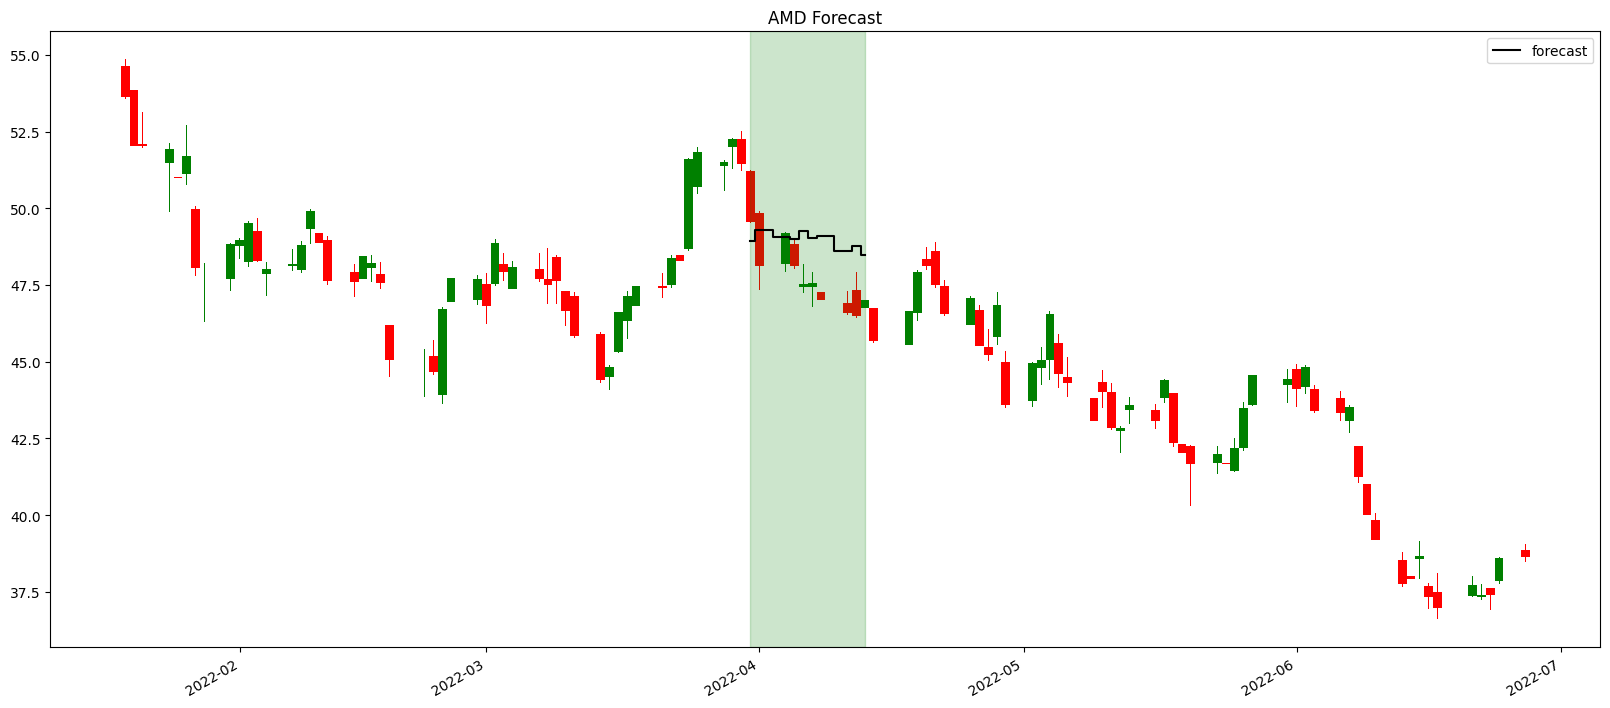

In [10]:
import matplotlib.pyplot as plt 

candles_back = 500
lpadding = 50
rpadding = 50

rlim = rpadding-candles_back if candles_back > rpadding else None

df_display = df.iloc[-lpadding-output_length-candles_back:rlim]

up = df_display[df_display['Close'] >= df_display['Open']]
down = df_display[df_display['Close'] < df_display['Open']] 
col1 = 'green'
col2 = 'red'
width = 1
width2 = .1


plt.figure(figsize=(20,8))

# Plotting up prices of the stock 
plt.bar(up.index, up['Close']-up['Open'], width, bottom=up['Open'], color=col1) 
plt.bar(up.index, up['High']-up['Close'], width2, bottom=up['Close'], color=col1) 
plt.bar(up.index, up['Low']-up['Open'], width2, bottom=up['Open'], color=col1) 
  
# Plotting down prices of the stock 
plt.bar(down.index, down['Close']-down['Open'], width, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['High']-down['Open'], width2, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['Low']-down['Close'], width2, bottom=down['Close'], color=col2) 
  
plt.step(df_display.index[lpadding:lpadding+output_length], preds[-output_length-candles_back-1], where='mid', label='forecast', color='black')

# rotating the x-axis tick labels at 30degree  
plt.xticks(rotation=30, ha='right') 
  
plt.legend()
plt.title('AMD Forecast')

plt.axvspan(df_display.index[lpadding], df_display.index[lpadding+output_length-1], color='green', alpha=0.2)
  
plt.show() 